## Task 2

Task description: 

In this task, we are asked to encode the data with 4 features in qubits in a quantum circuit. Then, we are asked to design a variational quantum circuit for a binary classifier (classes 0 and 1). This is essentially a supervised learning problem. We will use the `PennyLane` library for this task.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let us load the (training and testing) data and store them as numpy arrays.

In [2]:
train_data = pd.read_csv('mock_train_set.csv')
train_data = train_data.astype({"0": float, "1":float, "2":float, "3":float, "4":int})
test_data = pd.read_csv('mock_test_set.csv')
test_data = test_data.astype({"0": float, "1":float, "2":float, "3":float, "4":int})
print(train_data.shape)
print(test_data.shape)

(300, 5)
(120, 5)


In [3]:
train_feat = train_data[["0", "1", "2", "3"]].to_numpy()
train_labels = train_data["4"].to_numpy()
test_feat = test_data[["0", "1", "2", "3"]].to_numpy()
test_labels = test_data["4"].to_numpy()

In [4]:
# Feature data normalized to unit vectors (with unit norm)
norm_train = np.sqrt(np.sum(train_feat**2, -1))
X_train = (train_feat.T/norm_train).T
X_train.requires_grad=False
# Convert labels to 1 and -1
Y_train = np.array(1 - 2*train_labels, requires_grad=False)

norm_test = np.sqrt(np.sum(test_feat**2, -1))
X_test = (test_feat.T/norm_test).T
X_test.requires_grad=False
# Convert labels to 1/-1
Y_test = np.array(1 - 2*test_labels, requires_grad=False)

### 1. Amplitude Encoding

To encode 4 features using amplitude encoding, we need only 2 qubits. The 4 (normalized) features correspond to the amplitudes of the $\{\ket{00}, \ket{01}, \ket{10}, \ket{11}\}$ states. For convience, we use the `AmplitudeEmbedding` template provided by PennyLane.

In [19]:
def square_loss(labels, predictions):
    """
    Computes the standard square loss between model predictions and true labels.

    Args:
        - labels (list(int)): true labels (1/-1)
        - predictions (list(int)): model predictions (1/-1)

    Returns:
        - loss (float): the square loss
    """

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    """
    Computes the accuracy of the model's predictions against the true labels.

    Args:
        - labels (list(int)): true labels (1/-1)
        - predictions (list(int)): model predictions (1/-1)

    Returns:
        - acc (float): the accuracy
    """

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

def AmpEnc_Classifier(train_sets, train_labels, num_layers, test_sets=None, test_labels=None):
    """
    Train the classifier model based on amplitude embedding and computes the accuracy of the predections based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_train (float): accuracy of the predictions based on the training dataset
        - acc_val (float): accuracy of the predictions based on the validation dataset
        - acc_test (float): accuracy of the predictions based on the testing dataset
    """

    dev = qml.device("lightning.qubit", wires=2)

    def layer(W):
        # Start with a simple layer with RX, RY, RZ, and CNOT gates
        for i in range(2):
            qml.RX(W[i,0], wires=i)
            qml.RY(W[i,1], wires=i)
            qml.RZ(W[i,2], wires=i)
        qml.CNOT(wires=[0,1])

    @qml.qnode(dev)
    def circuit(weights, x):
        qml.AmplitudeEmbedding(x, wires=range(2))
        for W in weights:
            layer(W)
        return qml.expval(qml.PauliZ(1))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 2, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.AdagradOptimizer(0.05)
    batch_size = 5
    max_iters = 100

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_train, acc_val, acc_test

In [229]:
# Example: num_layers = 3
AmpEnc_Classifier(X_train, Y_train, 3)

Iter:     0 | Cost: 1.7325568 | Acc train: 0.1866667 | Acc validation: 0.1066667 
Iter:    10 | Cost: 1.1136979 | Acc train: 0.3644444 | Acc validation: 0.2666667 
Iter:    20 | Cost: 0.8126287 | Acc train: 0.7777778 | Acc validation: 0.8533333 
Iter:    30 | Cost: 0.6979803 | Acc train: 0.8088889 | Acc validation: 0.8666667 
Iter:    40 | Cost: 0.6376943 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    50 | Cost: 0.5945344 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    60 | Cost: 0.5765815 | Acc train: 0.8088889 | Acc validation: 0.8533333 
Iter:    70 | Cost: 0.5548693 | Acc train: 0.8133333 | Acc validation: 0.8533333 
Iter:    80 | Cost: 0.5480861 | Acc train: 0.8133333 | Acc validation: 0.8533333 
Iter:    90 | Cost: 0.5376484 | Acc train: 0.8177778 | Acc validation: 0.8933333 
Iter:   100 | Cost: 0.5353288 | Acc train: 0.8177778 | Acc validation: 0.8666667 
Iter:   110 | Cost: 0.5326254 | Acc train: 0.8177778 | Acc validation: 0.8666667 
Iter:   120 | Co

Next, let's investigate how the accuracy of the testing dataset changes with the number of layers. The number of iterations is fixed to be 50.

In [17]:
# max_iter = 50
acc_train_amp = []
acc_val_amp = []
acc_test_amp = []

for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = AmpEnc_Classifier(X_train, Y_train, num_layers, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_amp.append(acc_train)
    acc_val_amp.append(acc_val)
    acc_test_amp.append(acc_test)

Layers:     1 | Acc train: 0.8266667 | Acc validation: 0.8133333 | Acc test: 1.0000000
Layers:     2 | Acc train: 0.8177778 | Acc validation: 0.8666667 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8444444 | Acc validation: 0.8266667 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.7955556 | Acc validation: 0.8933333 | Acc test: 1.0000000
Layers:     5 | Acc train: 0.8355556 | Acc validation: 0.8133333 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8311111 | Acc validation: 0.8266667 | Acc test: 1.0000000


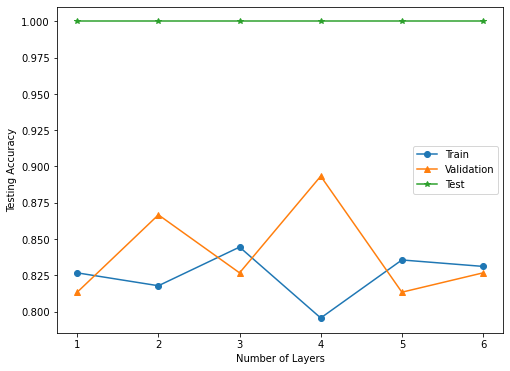

In [18]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_amp, '-o', label='Train')
plt.plot(x, acc_val_amp, '-^', label="Validation")
plt.plot(x, acc_test_amp, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

It seems from the plot above that we can achieve perfect accuracy with the test dataset using minimally one layer, but as I ran the VQC multiple times, I found that this result is not always reliable. Having minimally 2 layers can almost always guarantee a perfect accuracy with the test dataset. On the other hand, the training and validation accuracies retain at similar levels (80-90%) and they do not show obvious improvements as the number of layers increases.

What if we increase the number of iterations to 100? How do the accuracies scale with the number of layers?

In [20]:
# max_iter = 100
acc_train_amp_1 = []
acc_val_amp_1 = []
acc_test_amp_1 = []

for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = AmpEnc_Classifier(X_train, Y_train, num_layers, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_amp_1.append(acc_train)
    acc_val_amp_1.append(acc_val)
    acc_test_amp_1.append(acc_test)

Layers:     1 | Acc train: 0.8177778 | Acc validation: 0.8666667 | Acc test: 1.0000000
Layers:     2 | Acc train: 0.8000000 | Acc validation: 0.8800000 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8177778 | Acc validation: 0.8800000 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.8488889 | Acc validation: 0.7866667 | Acc test: 1.0000000
Layers:     5 | Acc train: 0.8533333 | Acc validation: 0.8000000 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8311111 | Acc validation: 0.8266667 | Acc test: 1.0000000


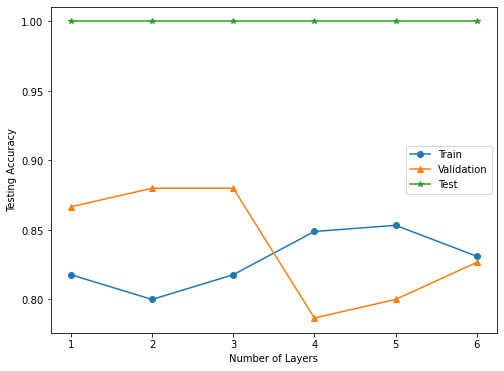

In [21]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_amp_1, '-o', label='Train')
plt.plot(x, acc_val_amp_1, '-^', label="Validation")
plt.plot(x, acc_test_amp_1, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

Similar to the case of 50 iterations above, one can achieve 100% accuracy on the test dataset using minimally one layer of variational ansatz used here. However, the training and validation accuracies do not see obvious improvements as we increase the number of iterations to 100 or we increase the number of layers.

### 2. Angle Encoding

For angle encoding, we encode the 4 features into rotation angles (e.g. RY rotations) of 4 qubits. For convience, we use the `AngleEmbedding` template provided in PennyLane.

In [26]:
def AngEnc_Classifier(train_sets, train_labels, num_layers, num_iters, test_sets=None, test_labels=None):
    """
    Train the classifier model based on angle embedding (RY) and computes the accuracy of the predictions based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - num_iters (int): number of iterations of training
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_train (float): accuracy of the predictions based on the training dataset
        - acc_val (float): accuracy of the predictions based on the validation dataset
        - acc_test (float): accuracy of the predictions based on the testing dataset
    """

    dev = qml.device("lightning.qubit", wires=4)

    def layer(W):
        # Start with a simple layer with RX, RY, RZ, and CNOT gates
        for i in range(4):
            qml.RX(W[i,0], wires=i)
            qml.RY(W[i,1], wires=i)
            qml.RZ(W[i,2], wires=i)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[1,2])
        qml.CNOT(wires=[2,3])
        qml.CNOT(wires=[3,1])

    @qml.qnode(dev)
    def circuit(weights, x):
        qml.AngleEmbedding(x, wires=range(4), rotation='Y')
        for W in weights:
            layer(W)
        return qml.expval(qml.PauliZ(0))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 4, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.optimize.AdamOptimizer(0.05)
    batch_size = 5
    max_iters = num_iters

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_train, acc_val, acc_test

In [27]:
# With 50 iterations
acc_train_ang = []
acc_val_ang = []
acc_test_ang = []
for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = AngEnc_Classifier(X_train, Y_train, num_layers, 50, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_ang.append(acc_train)
    acc_val_ang.append(acc_val)
    acc_test_ang.append(acc_test)

Layers:     1 | Acc train: 0.8355556 | Acc validation: 0.8533333 | Acc test: 1.0000000
Layers:     2 | Acc train: 0.8311111 | Acc validation: 0.8266667 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8222222 | Acc validation: 0.8133333 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.8088889 | Acc validation: 0.8000000 | Acc test: 0.9083333
Layers:     5 | Acc train: 0.8177778 | Acc validation: 0.8533333 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8266667 | Acc validation: 0.8266667 | Acc test: 1.0000000


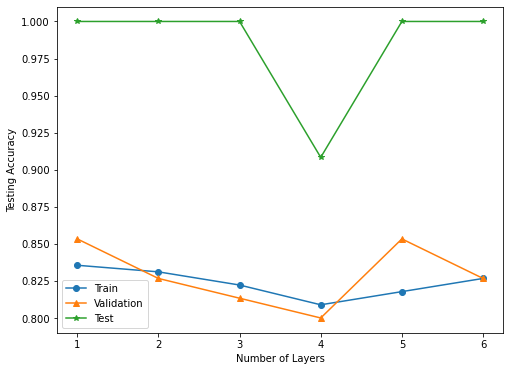

In [28]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_ang, '-o', label='Train')
plt.plot(x, acc_val_ang, '-^', label="Validation")
plt.plot(x, acc_test_ang, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

Overall, the accuracies with angle encoding are quite similar to the case of amplitude encoding (with the same variational ansatz and the same number of iterations). We do notice smaller variations/fluctuations in the training and validation accuracies as the number of layers increases. However, we also find that the testing accuracy drops below 100% when the number of layers is 4, which seems unusual. The reason for this could be that the variational ansatz for angle encoding has more parameters than that for amplitude encoding because one has to use more qubits ($N$ vs. $\log_2 N$ for $N$ features). Therefore, it may take more iterations to train a circuit with angle encoding for it to reach the maximal accuracy.

What if we now increase the number of iterations to 100?

In [30]:
# With 100 iterations
acc_train_ang_1 = []
acc_val_ang_1 = []
acc_test_ang_1 = []
for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = AngEnc_Classifier(X_train, Y_train, num_layers, 100, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_ang_1.append(acc_train)
    acc_val_ang_1.append(acc_val)
    acc_test_ang_1.append(acc_test)

Layers:     1 | Acc train: 0.7733333 | Acc validation: 0.7866667 | Acc test: 0.9833333
Layers:     2 | Acc train: 0.7955556 | Acc validation: 0.8533333 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8444444 | Acc validation: 0.8133333 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.8355556 | Acc validation: 0.8400000 | Acc test: 1.0000000
Layers:     5 | Acc train: 0.8355556 | Acc validation: 0.8000000 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8088889 | Acc validation: 0.8800000 | Acc test: 1.0000000


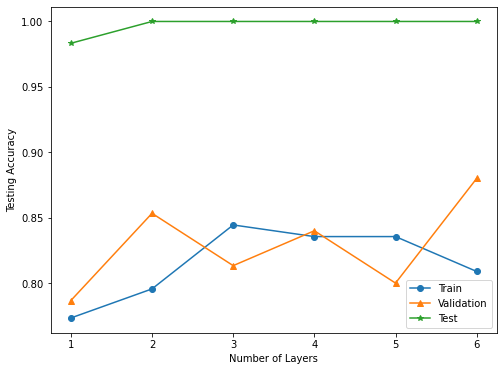

In [31]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_ang_1, '-o', label='Train')
plt.plot(x, acc_val_ang_1, '-^', label="Validation")
plt.plot(x, acc_test_ang_1, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

As before, while we do not see clear improvements in the training and validation accuracies, we no longer see a drop in the testing accuracy as the number of layers increases in this case. We therefore expect the variance of the testing accuracy to decrease as the number of iterations increases. 

### 3. Instantaneous Quantum Polynomial (IQP) Encoding 

Now we try yet another way of feature encoding called the instantaneous quantum polynomial (IQP) encoding, which was introduced in [this paper](https://arxiv.org/pdf/1804.11326.pdf). See also [here](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.IQPEmbedding.html) for a simple introduction and the circuit diagram. Also, instead of using the ansatz that we have been using previously, we will use one of PennyLane's built-in template layers, [`StronglyEntanglingLayers`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.StronglyEntanglingLayers.html), which is basically composed of the U3 rotation gates on each of the qubits and CNOT gates on all possible permutations of pairs of qubits. It is actually very similar to the ansatz used previously.

In [32]:
def IQPEnc_Classifier(train_sets, train_labels, num_layers, num_iters, test_sets=None, test_labels=None):
    """
    Train the classifier model based on IQP encoding and computes the accuracy of the predictions based on the testing data.

    Args:
        - train_sets (np.ndarray): features of the training datasets
        - train_labels (np.ndarray): labels (categories) of the training datasets
        - num_layers (int): number of layers of the variational ansatz
        - num_iters (int): number of iterations of training
        - test_sets (np.ndarray): features of the testing datasets
        - test_labels (np.ndarray): labels (categories) of the testing datasets

    Returns:
        - acc_train (float): accuracy of the predictions based on the training dataset
        - acc_val (float): accuracy of the predictions based on the validation dataset
        - acc_test (float): accuracy of the predictions based on the testing dataset
    """

    dev = qml.device("lightning.qubit", wires=4)

    # Manual IQP encoding
    def state_prep(x):
        S = [[0,1],[1,2],[2,3]]
        for i in range(4):
            qml.Hadamard(wires=i)
        for j in range(4):
            qml.RZ(x[j], wires=j)
        for k in S:
            qml.CNOT(wires=k)
            qml.RZ(x[k[0]]*x[k[1]], wires=k[1])
            qml.CNOT(wires=k)

    @qml.qnode(dev)
    def circuit(weights, x):
        # qml.IQPEmbedding(x, wires=range(4))
        state_prep(x)
        # Use Pennylane's StronglyEntanglingLayers as layers
        qml.templates.layers.StronglyEntanglingLayers(weights, wires=range(4))
        return qml.expval(qml.PauliZ(0))

    def var_classifier(weights, bias, x):
        return circuit(weights, x) + bias
    
    def cost(weights, bias, X, Y):
        predictions = [var_classifier(weights, bias, x) for x in X]
        return square_loss(predictions, Y)

    # Set up the training procedure
    data_size = len(train_sets)
    train_size = int(0.75*data_size)
    index = np.random.permutation(range(data_size))
    X_train = train_sets[index[:train_size]]
    Y_train = train_labels[index[:train_size]]
    X_val = train_sets[index[train_size:]]
    Y_val = train_labels[index[train_size:]]

    init_weights = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, 4, 3), requires_grad=True)
    init_bias = np.array(0.0, requires_grad=True)
    opt = qml.optimize.AdamOptimizer(0.05)
    batch_size = 5
    max_iters = num_iters

    weights = init_weights
    bias = init_bias

    for i in range(max_iters+1):
        batch_index = np.random.randint(0, train_size, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        predictions_train = [np.sign(var_classifier(weights, bias, x)) for x in X_train]
        predictions_val = [np.sign(var_classifier(weights, bias, x)) for x in X_val]

        # Compare accuracy on train and validation sets
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if test_sets is None and test_labels is None:
            if i%10 == 0:
                print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(i, cost(weights, bias, train_sets, train_labels), acc_train, acc_val)
                )

    if test_sets is None and test_labels is None:
        pass 
    else:
        predictions_test = [np.sign(var_classifier(weights, bias, x)) for x in test_sets]
        acc_test = accuracy(test_labels, predictions_test)
        return acc_train, acc_val, acc_test

In [33]:
# With 50 iterations
acc_train_IQP = []
acc_val_IQP = []
acc_test_IQP = []
for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = IQPEnc_Classifier(X_train, Y_train, num_layers, 50, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_IQP.append(acc_train)
    acc_val_IQP.append(acc_val)
    acc_test_IQP.append(acc_test)

Layers:     1 | Acc train: 0.7822222 | Acc validation: 0.7466667 | Acc test: 0.8833333
Layers:     2 | Acc train: 0.8222222 | Acc validation: 0.8266667 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8222222 | Acc validation: 0.8400000 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.7955556 | Acc validation: 0.8133333 | Acc test: 0.9083333
Layers:     5 | Acc train: 0.8400000 | Acc validation: 0.8000000 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8311111 | Acc validation: 0.8266667 | Acc test: 1.0000000


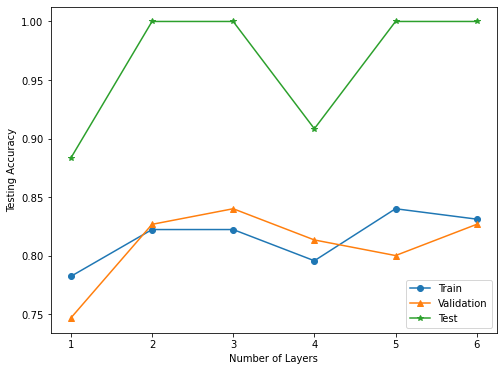

In [34]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_IQP, '-o', label='Train')
plt.plot(x, acc_val_IQP, '-^', label="Validation")
plt.plot(x, acc_test_IQP, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

In [35]:
# With 100 iterations
acc_train_IQP_1 = []
acc_val_IQP_1 = []
acc_test_IQP_1 = []
for num_layers in range(1, 7):
    acc_train, acc_val, acc_test = IQPEnc_Classifier(X_train, Y_train, num_layers, 100, X_test, Y_test)
    print("Layers: {:5d} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}".format(num_layers, acc_train, acc_val, acc_test))
    acc_train_IQP_1.append(acc_train)
    acc_val_IQP_1.append(acc_val)
    acc_test_IQP_1.append(acc_test)

Layers:     1 | Acc train: 0.8355556 | Acc validation: 0.7333333 | Acc test: 0.9083333
Layers:     2 | Acc train: 0.8222222 | Acc validation: 0.8533333 | Acc test: 1.0000000
Layers:     3 | Acc train: 0.8311111 | Acc validation: 0.8533333 | Acc test: 1.0000000
Layers:     4 | Acc train: 0.8088889 | Acc validation: 0.8933333 | Acc test: 1.0000000
Layers:     5 | Acc train: 0.8311111 | Acc validation: 0.8266667 | Acc test: 1.0000000
Layers:     6 | Acc train: 0.8400000 | Acc validation: 0.8266667 | Acc test: 1.0000000


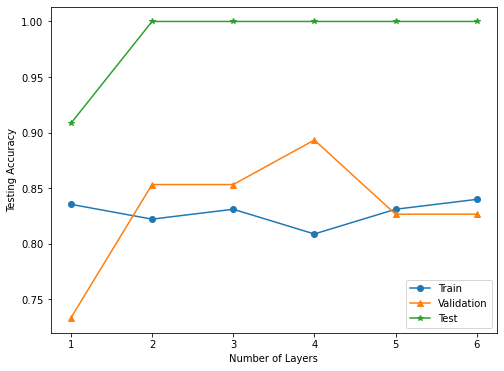

In [36]:
plt.figure(figsize=(8,6))
x = [i for i in range(1, 7)]
plt.plot(x, acc_train_IQP_1, '-o', label='Train')
plt.plot(x, acc_val_IQP_1, '-^', label="Validation")
plt.plot(x, acc_test_IQP_1, '-*', label='Test')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")
plt.show()

The overall performance with IQP encoding is similar to that of angle encoding, as IQP is a special form of angle encoding itself. A good thing to note is that the training and validation accuracies with IQP encoding are consistently (but just slightly) higher than those with angle encoding with RY gates. As before, having 50 iterations cannot always guarantee a perfect testing accuracy as the number of layer increases, but 100 iterations seem to do the job well for up to 6 layers. Last thing to note is that IQP encoding is believed to make the encoding "richer" through interference, especially for larger feature sets.

### 4. Conclusion

In conclusion, we have built a quantum binary classifier in three different ways of encoding the classical data: amplitude encoding, angle encoding, and IQP encoding. While the first way of encoding requires $\log_2 N$ qubits for $N$ features, the other two require $N$ qubits. From the results above, we have the following findings:
- For all of the encoding methods used above, having minimally 2 layers of the variational ansatz (with RX, RY, RZ, and CNOT gates) and 100 iterations can almost always guarantee perfect accuracy (100%) on the testing dataset. In general, angle encoding and IQP encoding requires more iterations of training because they require more qubits and hence more parameters in the variational ansatz.
- However, with a fixed number of iterations, the training and validation accuracies do not show clear improvements with an increasing number of layers. They seem to retain at a level of 80-90% in most cases.
- Practically, the quantum circuit with amplitude embedding takes less time to train because of fewer number of qubits used, given the same variational ansatz and number of iterations. In the meantime, it gives similar accuracies compared to the other two methods.
- One of the reasons we can relatively easily achieve high accuracies with the these data is because they are easily separable with two of the features corresponding to the 1- and 2-columns. Basically, by eyeballing the data, when the values of these two columns are much larger than the those of other features, the class is 1, and the class is 0 when they are small. A mathematical way to formulate this is that for each data point $\vec x^{(i)}$, if $\lvert x^{(i)}_1\rvert^2 + \lvert x^{(i)}_2\rvert^2 \gg \lvert x^{(i)}_0\rvert^2 + \lvert x^{(i)}_3\rvert^2$, then the class is 1, otherwise it is 0. To see this visually, we can plot the testing data in the feature space with just these two features.

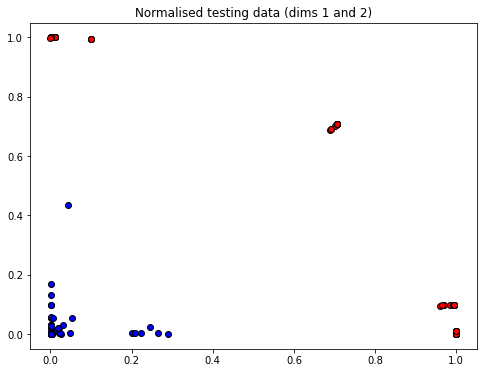

In [40]:
plt.figure(figsize=(8,6))
dim1 = 1
dim2 = 2
plt.scatter(
    X_test[:, dim1][Y_test == 1], X_test[:, dim2][Y_test == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_test[:, dim1][Y_test == -1], X_test[:, dim2][Y_test == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Normalised testing data (dims {} and {})".format(dim1, dim2))
plt.show()